# Making predictions
Predicting artist gender and genre from song lyrics
A follow-up to [*Trucks and Beer*](http://www.johnwmillr.com/trucks-and-beer/), my textual analysis of 12k+ country song lyrics

---

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import re
from collections import Counter

In [97]:
# Change the Matplotlib defaults
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
plt.rcParams.update({'font.size': 16, 'figure.figsize': (12.0, 6.0)})
plt.style.use('seaborn')
%matplotlib inline

---
## Load the data

In [2]:
songs = pd.read_json('./data/lyrics/all_songs.json')
songs.drop(columns=['raw'], inplace=True)
genres = songs.genre.unique()
print(genres)

In [219]:
artist = songs[songs.artist=='The Beatles']
artist.head(2)

,album,artist,gender,genre,image,lyrics,title,year,word_count
34290,Let It Be,The Beatles,male,rock,https://images.genius.com/1f61e7c20f3ec7d82362...,Words are flowing out like endless rain into a...,Across the Universe,1969-12-12,144
34291,Help!,The Beatles,male,rock,https://images.genius.com/adbf27acc77a06acfa4a...,They're gonna put me in the movies\nThey're go...,Act Naturally,1965-08-06,113


# Explore the data

## Write a text tokenizer

Virtually any textual analysis will involve tokenizing the text. Tokenization refers to splitting a body of text into individual "tokens", which - for my purposes - is equivalent to individual words. It's also common practice to remove [stop words](https://en.wikipedia.org/wiki/Stop_words) such as "the", "and", or "but", as their usage may not be characteristic to the text of interest.

In [7]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
punctuation = "".join([symbol for symbol in punctuation if symbol not in ["'", '"']])
punctuation += '–'

# We'll use these helper functions throughout the analysis
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def tokenizeText(txt, remove_stop_words=True):
    """Splits a string of text into individual words"""
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = [w for w in clean_str(txt).split() if w not in stop_words]
    words = ['N-Word' if w in ['nigga', 'niggas'] else w for w in words]
    return words

At the start of any analysis, it's helpful to visualize the data and get a rough sense for how they behave.

For textual analyses, a few common metrics are `words_per_sample` and `word_frequency_distributions`

### `words_per_song`

Whenever possible (within reason), it's helpful to keep features contained within the same DataFrame. So we'll calculate each song's word count and add the value to the corresponding row in the `pandas` DataFrame.

In [31]:
word_counts = [len(tokens) for tokens in map(tokenizeText, songs.lyrics)]
songs['word_count'] = word_counts

With the new `word_count` column added to the DataFrame, we can use the `groupby` and `plot.hist` commands to generate a histogram of word per song for each genre.

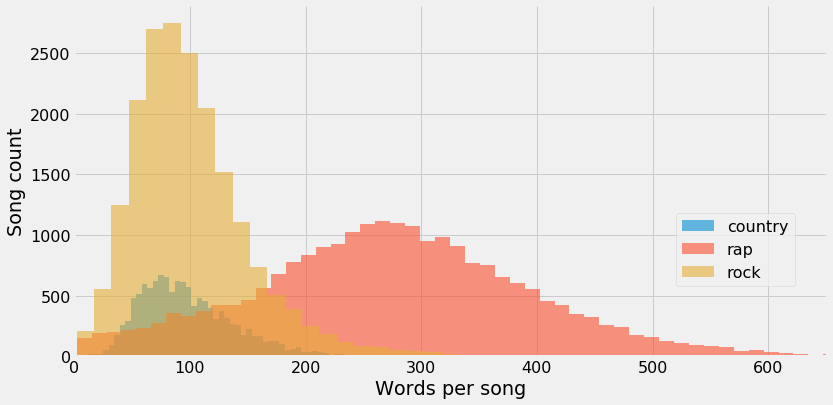

In [176]:
# Words per song by genre
fig, ax = plt.subplots()
songs.groupby('genre').word_count.plot.hist(bins=500, ax=ax, alpha=0.6)

# Touch up the plot
ax.legend(loc=(0.8, 0.2))
ax.set(xlabel='Words per song', ylabel='Song count', xlim=(0, 650))
[ax.spines[s].set_visible(False) for s in ax.spines if s in ['right', 'top']];
plt.show()

***Class Imbalance***

This histogram also shows us that we have a bit of a [class imbalance](https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2). There are about 20k song lyrics for rap and rock, but only 12k for country. If the number of samples between classes is too imbalanced when training a model, there's a risk the model will be improperly biased towards predicting certain genres over others. I don't think we have too bad of an imbalance, so I'm hoping we don't need to address the issue now.

However, going forward, it may be helpful to account for this imbalance in our visualizations. With the `plt.hist` command, we can set the `density` option to `True`, which will normalize the distributions based on the number of samples in each class.

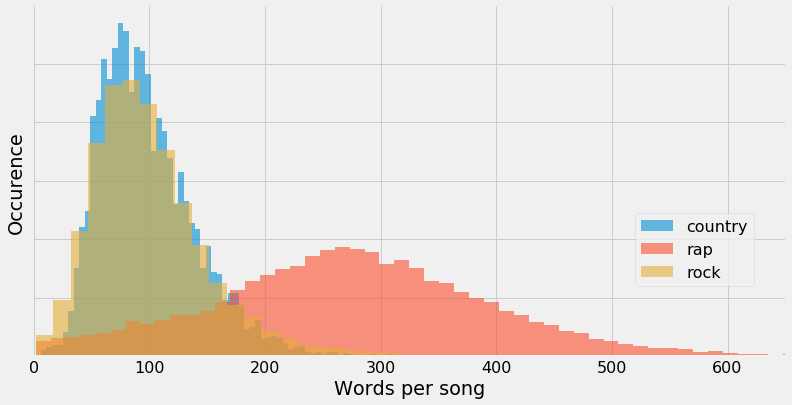

In [183]:
# Words per song by genre
fig, ax = plt.subplots()
songs.groupby('genre').word_count.plot.hist(bins=500, ax=ax, alpha=0.6, density=True)

# Touch up the plot
ax.legend(loc=(0.8, 0.2))
ax.set(xlabel='Words per song', ylabel='Occurence', yticklabels=[], xlim=(0, 650))
ax.tick_params(axis='y', which='both', left=False)
[ax.spines[s].set_visible(False) for s in ax.spines if s in ['right', 'left', 'top']];
plt.show()

This simple histogram is actually quite helpful - it tells us that *words per song* is a useful metric for differentiating rap songs from rock and country, but the feature won't be helpful for distinguishing between the latter two genres.

### `word_frequency_distributions`

It's also common practice in textual analyses to look at word frequency distributions. Knowing which words are used most often is a simple but effective way to begin to characterize a text's vocabulary.

In [204]:
# Calculate a frequency distribution of terms for each genre
freqdists = {}
for genre in genres:
    song_tokens = list(map(tokenizeText, songs[songs.genre==genre].lyrics))
    tokens = [word for song in song_tokens for word in song]
    freqdists[genre] = nltk.FreqDist(tokens)

In [205]:
# Write a function for plotting a pretty bar graph of an NLTK FreqDist
def plotFreqDist(fd, num_words=20, ax=None, color='b'):
    # Extract word counts and normalize to 'Usage per 10,000 words'
    words, counts = zip(*[(word,count) for word, count in fd.most_common(num_words)])
    counts = 10000*(np.asarray(counts)/fd.N())
    idxs = np.arange(num_words)

    # Make the plot
    if not ax:
        fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(idxs, counts, width=0.85, color=color, alpha=0.8)
    params = {'fontsize':FS-2, 'rotation':80, 'va':'bottom', 'ha':'center',
              'color':'white', 'alpha':1, 'weight':'heavy', 'zorder':5}
    for idx, word in zip(idxs, words):
        ax.text(idx, 2.6, word, fontdict=params)
    ax.tick_params(labelsize=FS, direction='out')
    ax.set(ylabel="Usage per 10,000 words", xticks=[], xlim=(-1, num_words))
                
    return ax        

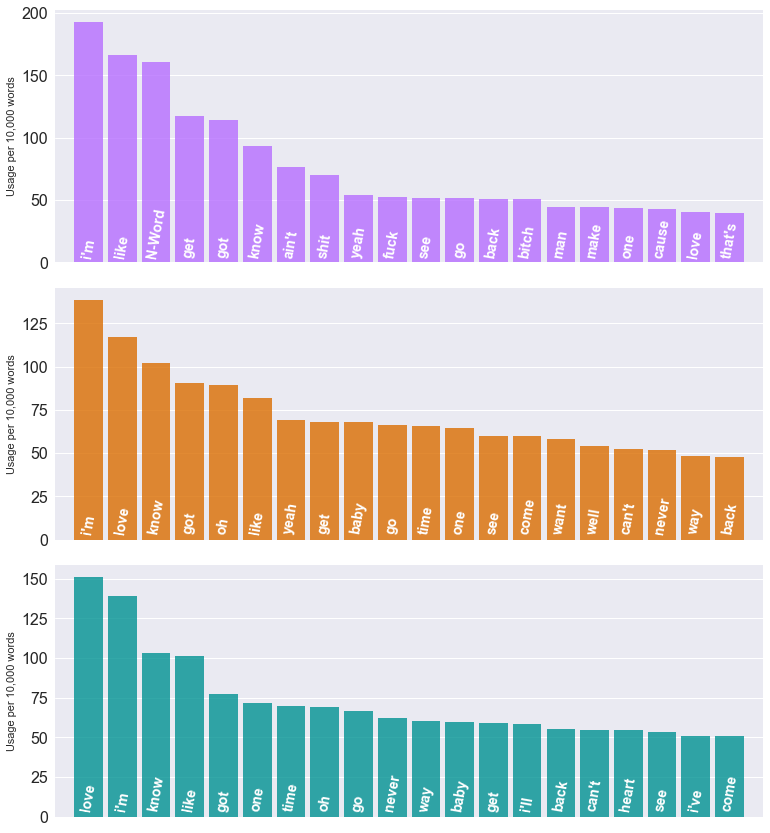

In [206]:
# Plot the twenty most popular words for each of the genres
fig, axs = plt.subplots(nrows=len(genres), figsize=(12, 14))
for n in range(len(axs)):
    plotFreqDist(freqdists[genres[n]], ax=axs[n], color=colors[n])

plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace=0.1)
plt.show()

### Section summary
By making these preliminary visualizations, we begin to get a sense for what features may be useful for differentiating between genres. For example, it looks like `words_per_song` may be helpful for identifying rap songs, but won't be all that useful for distinguishing between rock and country lyrics.

In the next section, we'll use these features to train a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to predict the genre of a song based on its lyrical content.

# Classification with NLTK

In [236]:
from nltk import NaiveBayesClassifier

As the size of the full song dataset would be prohibitive to work with in an exploratory manner, we'll start by creating a small random subset songs.

In [220]:
# Start by working with a subset of the full dataset
n = 500
tmp = []
for genre in genres:
    tmp.append(songs[songs.genre==genre].sample(n))
subset = pd.concat(tmp)

In [222]:
subset.head(1)

,album,artist,gender,genre,image,lyrics,title,year,word_count
16837,"I Don't Like Shit, I Don't Go Outside",Earl Sweatshirt,male,rap,https://images.genius.com/79df1d18a8b46756cc7a...,"I don't give a fuck, nigga\nSo why'd they evic...",Grown Ups,2015-03-23,217


In [223]:
# Tokenize the training text
song_tokens = list(map(tokenizeText, subset.lyrics))
tokens = [word for song in song_tokens for word in song]
fd = nltk.FreqDist(tokens)
n_features = 500
word_features = [word for word, count in fd.most_common(n_features)]

# Format the training data with genre labels
documents = [(tokens, genre) for tokens, genre in zip(song_tokens, subset.genre)]
random.shuffle(documents)

# Extract features from a list of words
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [237]:
# Train the classifier
featuresets = [(document_features(d), c) for (d,c) in documents]
idx_split = int(0.7 * len(featuresets))
train_set, test_set = featuresets[:idx_split], featuresets[idx_split:]
classifier = NaiveBayesClassifier.train(train_set)

# Evaluate the classifier
accuracy = 100*nltk.classify.accuracy(classifier, test_set)
print(f"The classification is {accuracy:.1f}% accurate.")

The classification is 73.3% accurate.


In [244]:
import random

In [287]:
# Get a qualitative sense of classifier performance
song_idxs = np.random.randint(0, songs.shape[0], 10)
for n in song_idxs:
    song = songs.iloc[n]        
    guess = classifier.classify(document_features(tokenizeText(song['lyrics'])))
    truth = song['genre']
    title = song['title']
    print(40 * '=' + '\n' + song['lyrics'][:163] + '\n' + 30 * '.' + '\n')
    print("Title ({n}): '{ti}'\nGuess: {g}\nTruth: {tr}\n".format(g=guess, tr=truth, n=n, ti=title))

I saw her walkin' down the street
I tell you all she sure looked neat
Lovely eyes and long black hair
She looked so nervous standing there
(Whistles)
Man's she's g
..............................

Title (52692): 'The Pickup'
Guess: rock
Truth: country

There's a place in the whiskey. Where I don't give a damnI just love everybodyAnd everbody loves who I am Bartender hit me won't you get me to that place in the wh
..............................

Title (47323): 'There's A Place In The Whiskey'
Guess: country
Truth: country

I just kissed you goodbye a half an hour ago
I know you've driven to the airport
But I just gotta pick up the phone
And hear you one more time
Saying my name
I mus
..............................

Title (54169): 'Why's It Feel So Long'
Guess: country
Truth: country

That mean I'm ballin' bitch
If ya didn't know, if you wasn't informed
Or somethin' like that, this is Da Drought 3
And um, check this out
Yeah, imagine wakin' up o
..............................

Title (5916

In [289]:
classifier.show_most_informative_features(10)

Most Informative Features
        contains(N-Word) = True              rap : rock   =    144.9 : 1.0
          contains(shit) = True              rap : countr =    128.2 : 1.0
         contains(bitch) = True              rap : countr =    101.7 : 1.0
         contains(y'all) = True              rap : rock   =     58.7 : 1.0
       contains(bitches) = True              rap : countr =     50.7 : 1.0
          contains(gon') = True              rap : countr =     45.7 : 1.0
           contains(ass) = True              rap : rock   =     43.8 : 1.0
          contains(dick) = True              rap : rock   =     39.9 : 1.0
            contains(yo) = True              rap : rock   =     39.1 : 1.0
          contains(fuck) = True              rap : rock   =     38.1 : 1.0


## Data Preparation

### Vectorization
We need to convert the raw text into numbers. We'll do this in two steps:
  1. Tokenization
  2. Encoding

### Word embedding

### TF-IDF
I want a function that takes two inputs:
  - Text of interest (e.g. rap lyrics)
  - Full corpus (e.g. rap, rock, country lyrics)
  
and outputs the TF-IDF scores for the 100 terms with the highest TF-IDF scores

In [643]:
def calcTFIDF(corpus, txt, term):
    """Return the tf-idf scores for a term in a text"""
    # Tokenize the corpus and text of interest
    
#     tmp = list(map(tokenizeText, corpus))
#     tok_corpus = []
#     for item in tmp:
#         tok_corpus.extend(item)
        
    doc_count = 0
    for doc in corpus:
        if term in doc:
            doc_count += 1
    
    tmp = list(map(tokenizeText, txt))
    tok_txt = []
    for item in tmp:
        tok_txt.extend(item)
        
    assert doc_count > 0, f"Term '{term}' not found in corpus."
#     print(tok_txt.count(term))
#     print(doc_count)
    return tok_txt.count(term) / doc_count

In [640]:
# Create a small corpus for quick testing
n = 10000
small_songs = pd.concat([songs[songs.genre==genre].sample(n) for genre in genres])
subset_rap = songs[songs.genre=='rap'].sample(n)
subset_rock = songs[songs.genre=='rock'].sample(n)
subset_country = songs[songs.genre=='country'].sample(n)

In [641]:
small_songs.head(2)

,album,artist,gender,genre,image,lyrics,raw,title,year
8811,Immobilarity,Raekwon,male,rap,https://images.genius.com/d8508796401925d32124...,This paperwork is just fuckin' my eyes up. Shi...,"{'annotation_count': 3, 'api_path': '/songs/10...",Intro,1999-10-26
504,2Pacalypse Now,2Pac,male,rap,https://images.genius.com/839619da9eb2d92ecf53...,Killing us one by one\nIn one way or another\n...,"{'annotation_count': 29, 'api_path': '/songs/6...",Words of Wisdom,1991-11-12


In [644]:
# Sanity check the TF-IDF function
for term in ['beer', 'truck', 'girl', 'love', 'like']:
    print(30*'-')
    for subset in [subset_rap, subset_rock, subset_country]:
        tfidf = calcTFIDF(small_songs.lyrics, subset.lyrics, term)
        genre = subset.genre.iloc[0][:3]
        print(f"The TF-IDF score for '{term}' in {genre} music is: {tfidf:.3f}")

------------------------------
The TF-IDF score for 'beer' in rap music is: 0.321
The TF-IDF score for 'beer' in roc music is: 0.163
The TF-IDF score for 'beer' in cou music is: 1.035
------------------------------
The TF-IDF score for 'truck' in rap music is: 0.554
The TF-IDF score for 'truck' in roc music is: 0.060
The TF-IDF score for 'truck' in cou music is: 0.445
------------------------------
The TF-IDF score for 'girl' in rap music is: 1.133
The TF-IDF score for 'girl' in roc music is: 0.492
The TF-IDF score for 'girl' in cou music is: 0.534
------------------------------
The TF-IDF score for 'love' in rap music is: 0.867
The TF-IDF score for 'love' in roc music is: 0.936
The TF-IDF score for 'love' in cou music is: 1.134
------------------------------
The TF-IDF score for 'like' in rap music is: 3.023
The TF-IDF score for 'like' in roc music is: 0.555
The TF-IDF score for 'like' in cou music is: 0.645


In [102]:
tmp = list(map(tokenizeText, small_songs[small_songs.genre=='rap'].lyrics))
tokens = []
for item in tmp:
    tokens.extend(item)

In [108]:
100*len(set(tokens))/len(tokens)

3.3072071368198253

In [109]:
tmp = list(map(tokenizeText, small_songs[small_songs.genre=='country'].lyrics))
tokens = []
for item in tmp:
    tokens.extend(item)

In [110]:
100*len(set(tokens))/len(tokens)

2.7344686487958096

## gensim -- word2vec

In [ ]:
from gensim.models import Word2Vec

In [125]:
sentences = list(map(tokenizeText, small_songs[small_songs.genre=='rap'].lyrics))
model = Word2Vec(sentences, min_count=1)

In [132]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)  # train word vectors

(12834931, 14079100)

In [133]:
model.save('wv_rap.model')

## Feature Extraction with sklearn

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

In [238]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=1, tokenizer=tokenizeText)
bigram_analyze = bigram_vectorizer.build_analyzer()

In [240]:
bigram_analyze(songs.loc[0, 'lyrics'])

['death',
 'row',
 "that's",
 'where',
 'mothafuckas',
 'is',
 "endin'",
 'up',
 'dear',
 'mama',
 "i'm",
 'caught',
 'up',
 'in',
 'this',
 'sickness',
 'i',
 'robbed',
 'my',
 'adversaries',
 'but',
 'slipped',
 'and',
 'left',
 'a',
 'witness',
 'wonder',
 'if',
 "they'll",
 'catch',
 'me',
 'or',
 'will',
 'this',
 'nigga',
 'snitch',
 'should',
 'i',
 'shoot',
 'his',
 'bitch',
 'or',
 'make',
 'the',
 'nigga',
 'rich',
 "don't",
 'wanna',
 'commit',
 'murder',
 'but',
 'damn',
 'they',
 'got',
 'me',
 'trapped',
 "hawkin'",
 'while',
 "i'm",
 "walkin'",
 'and',
 "talkin'",
 'behind',
 'my',
 'back',
 "i'm",
 'kind',
 'of',
 'schizophrenic',
 "i'm",
 'in',
 'this',
 'shit',
 'to',
 'win',
 'it',
 '‘cause',
 "life's",
 'a',
 'wheel',
 'of',
 'fortune',
 "here's",
 'my',
 'chance',
 'to',
 'spin',
 'it',
 'got',
 'no',
 'time',
 'for',
 'cops',
 'who',
 'trip',
 'and',
 'try',
 'to',
 'catch',
 'me',
 'too',
 "fuckin'",
 'triggerhappy',
 'to',
 'let',
 'them',
 'suckers',
 'snatch',

### Creating a lyrics corpus
As we're hoping to classify rap and country songs, it'd be convenient to create a subset of lyrics that is cleaned up and ready to use for training and testing our model. Once we're happy with the model parameters, we can train and test the model on the entire dataset

In [448]:
# Create a subset of randomly sampled country and rap songs
n = 2000
tmp = []
for genre in ['rap', 'country']:
    tmp.append(songs[songs.genre==genre].sample(n))
subset = pd.concat(tmp)

# Create the lyrics corpus with genre and index labels
corpus = []
for lyrics, genre, index in zip(subset.lyrics, subset.genre, subset.index):
    corpus.append((lyrics, genre, index))
random.shuffle(corpus)
labels = [1 if song[1]=='country' else 0 for song in corpus]

In [351]:
X = bigram_vectorizer.fit_transform([doc[0] for doc in corpus]).toarray()
X.shape

(500, 92551)

In [352]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF with Scikitlearn

In [280]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer  

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [353]:
# counts = [[3, 0, 1],
#           [2, 0, 0],
#           [3, 0, 0],
#           [4, 0, 0],
#           [3, 2, 0],
#           [3, 0, 2]]

counts = X.copy()
tfidf = transformer.fit_transform(counts)
tfidf                         

# tfidf.toarray()  

<500x92551 sparse matrix of type '<class 'numpy.float64'>'
	with 212391 stored elements in Compressed Sparse Row format>

In [356]:
np.unique(tfidf.toarray())

array([0.        , 0.00159373, 0.00164575, ..., 0.75001679, 0.78151628,
       0.81001107])

Luckily, `tf-idf` text processing is common enough that `scikit-learn` provides a single class that combines both vectorization and transformation

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [357]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform([song[0] for song in corpus])

<500x11612 sparse matrix of type '<class 'numpy.float64'>'
	with 75749 stored elements in Compressed Sparse Row format>

In [358]:
# Feature names
feature_names = np.asarray(vectorizer.get_feature_names())

## Train a classifier
We'll start by training a random forest classifier, a robust model that should provide quite good accuracy without too much fiddling with hyperparameters.

In [298]:
from sklearn.ensemble import RandomForestClassifier

### Prepare the training and testing data
Before we can train the the model we need to prepare a set of training and testing data.

In [377]:
a,b = zip(*[(song[1], song[2]) for song in corpus[:3]])

In [382]:
# The corpus was shuffled upon creation, so it's okay to separate train/test sequentially
idx_split = int(0.70 * len(corpus))
X_train, y_train = zip(*[(analyze(song[0]), song[1]) for song in corpus[:3]])

In [299]:
clf = RandomForestClassifier(n_estimators=50)

In [ ]:
clf.fit

## K-means clustering
http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py

View the songs as points in a 2D (or 3D) TF-IDF space.

"Think about how cool this is! These techniques let us visually inspect 30k songs and immediately -- based simply on their location within this feature space -- get a sense for the style of music! We've reduced information from 30k songs and ?? million words into a simple two-dimensional scatter plot!"

In [388]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

In [489]:
# Perform TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, max_features=50,
                             min_df=2, tokenizer=tokenizeText,
                             use_idf=True)
X = vectorizer.fit_transform([song[0] for song in corpus])
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 4000, n_features: 50


In [476]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = [1 if song[1]=='rap' else 0 for song in corpus]
target_names = [song[1] for song in corpus]

pca = TruncatedSVD(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [494]:
# Perform dimensionality reduction
reduction_method = 'pca'
n_components = 10
t0 = time()
if reduction_method is 'lsa':

    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
else:
    # use PSA
    pca = TruncatedSVD(n_components=n_components)
    X = pca.fit(X).transform(X)
    explained_variance = pca.explained_variance_ratio_
            
print("done in %fs" % (time() - t0))    
print("Explained variance of the SVD step: {}%".format(100*sum(explained_variance)))

done in 0.051593s
Explained variance of the SVD step: 35.71878990986546%


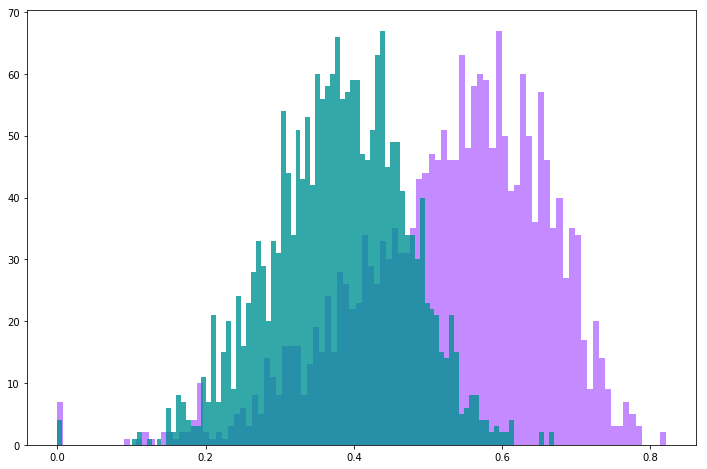

In [506]:
n_comp = 0
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(X[[True if s[1]=='rap' else False for s in corpus], n_comp], 100, color=colors[0], alpha=0.8)
ax.hist(X[[False if s[1]=='rap' else True for s in corpus], n_comp], 100, color=colors[2], alpha=0.8)
plt.show()

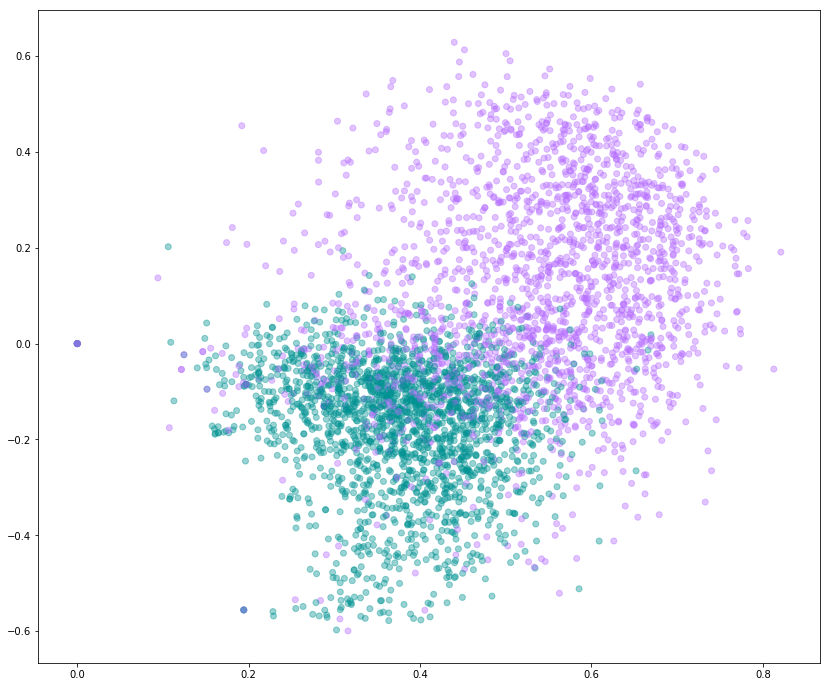

In [507]:
# View the songs in SVD space
fig, ax = plt.subplots(figsize=(14,12))
c = np.asarray([colors[0] if label==0 else colors[2] for label in labels])
ax.scatter(X[:,0], X[:,1], color=c, alpha=0.4)
plt.show()

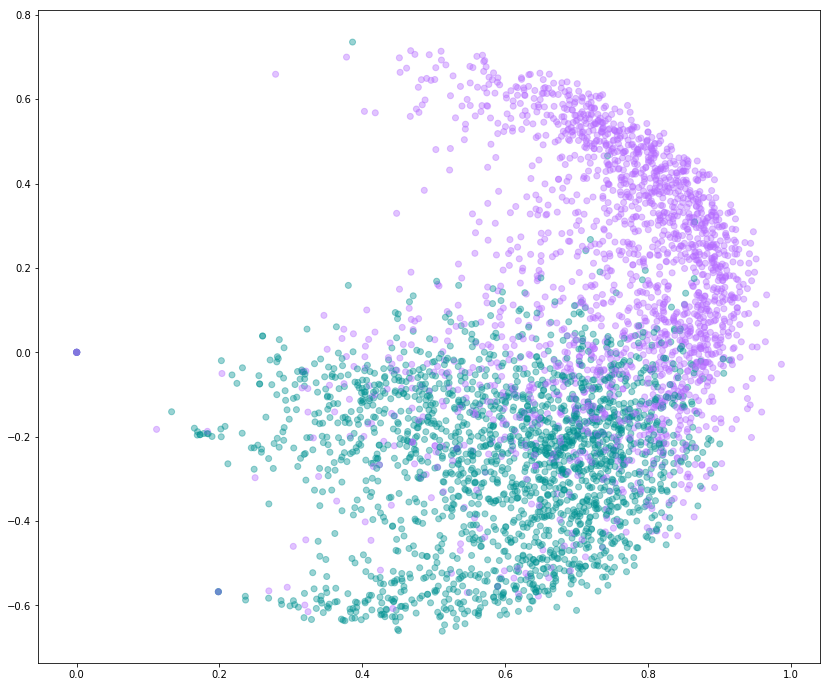

In [472]:
# View the songs in LSA space
fig, ax = plt.subplots(figsize=(14,12))
c = np.asarray([colors[0] if label==0 else colors[2] for label in labels])
ax.scatter(X[:,0], X[:,1], color=c, alpha=0.4)
plt.show()

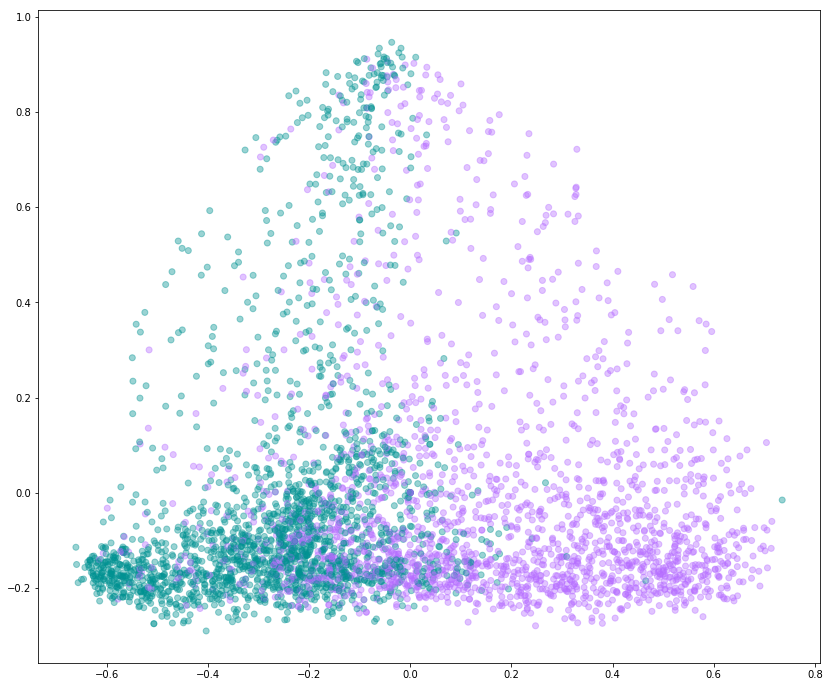

In [474]:
# View the songs in LSA space
fig, ax = plt.subplots(figsize=(14,12))
c = np.asarray([colors[0] if label==0 else colors[2] for label in labels])
ax.scatter(X[:,1], X[:,2], color=c, alpha=0.4)
plt.show()

In [508]:
# Perform K-means clustering
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1,
            verbose=True)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 999.3735725531906
start iteration
done sorting
end inner loop
Iteration 1, inertia 967.3763525567084
start iteration
done sorting
end inner loop
Iteration 2, inertia 962.3221528288277
start iteration
done sorting
end inner loop
Iteration 3, inertia 962.0173092477335
start iteration
done sorting
end inner loop
Iteration 4, inertia 961.9338021556172
start iteration
done sorting
end inner loop
Iteration 5, inertia 961.898151827455
start iteration
done sorting
end inner loop
Iteration 6, inertia 961.8882035989323
start iteration
done sorting
end inner loop
Iteration 7, inertia 961.881126662111
start iteration
done sorting
end inner loop
Iteration 8, inertia 961.8767810085214
center shift 1.50

In [509]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.346
Completeness: 0.405
V-measure: 0.374
Adjusted Rand-Index: 0.306
Silhouette Coefficient: 0.142


In [510]:
true_k = np.unique(labels).shape[0]

In [511]:
order_centroids

array([[20,  6, 10, 11, 29, 46, 42,  1, 25, 14, 22, 32, 27, 16,  7,  3,
        15, 45, 12,  4, 28, 21, 18, 31,  9, 47, 36, 19,  2, 44, 26, 49,
        37, 30, 41, 38, 40,  0, 43, 35,  8, 39, 33, 17, 48, 34, 23, 13,
        24,  5],
       [41, 23, 17, 33, 24,  0, 34, 45, 13,  5, 25, 48, 27, 39,  2, 16,
         8, 10, 12, 32,  4, 49, 35, 40, 11, 29, 38, 31, 18,  6, 14, 21,
        26, 22, 43,  9, 30, 42, 15,  1, 36, 44, 19, 37, 47,  7,  3, 46,
        28, 20]])

In [518]:
X_test = vectorizer.transform([song for song in songs.loc[:100, 'lyrics']])
pca = TruncatedSVD(n_components=n_components)
X_test = pca.fit(X_test).transform(X_test)

In [520]:
sum(km.predict(X_test))

58

In [521]:
['rap' if val==1 else 'country' for val in km.predict(X_test)]

['rap',
 'rap',
 'rap',
 'rap',
 'country',
 'rap',
 'country',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'rap',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'country',
 'country',
 'rap',
 'rap',
 'rap',
 'country',
 'rap',
 'country',
 'rap',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'country',
 'rap',
 'country',
 'rap',
 'country',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'rap',
 'country',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'rap',
 'country',
 'rap',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'country',
 'rap',
 'rap',
 'country',
 'country',
 'country',
 'country',
 'rap',
 'rap',
 'rap',
 'country',
 'rap',
 'country',
 'rap',
 'rap',
 'rap',
 'country']

In [522]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
true_k = np.unique(labels).shape[0]
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: ain't as back bitch can come can't cause at baby
Cluster 1: ain't baby at bitch come can't can cause back as


---
## Notes

I could frame this post in part as an extension of this [Pudding piece](https://pudding.cool/2017/09/hip-hop-words/) on the most typical hip-hop words. They identified words that were unique to different genres, but didn't use that information to *train a classifier*

I should compare my performance to other papers:
  - https://arxiv.org/abs/1707.04678
  - https://nlp.stanford.edu/courses/cs224n/2006/fp/sadovsky-x1n9-1-224n_final_report.pdf
  - https://github.com/ianscottknight/Musical-Genre-Classification-of-Song-Lyrics

sklearn tutorial on optimizing the classifier hyperparameter tuning: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

# Review
 - What features are most useful for classifying genre? And for gender?
 - Have a "possible applications" section at end of post